In [253]:
# Performance!

In [253]:
from importlib import reload
import sys
sys.path.append("../evaluation/")
import evaluation_methods
reload(evaluation_methods)
from evaluation_methods import remap_annos_best_match, remap_annos_best_match_many_documents, calc_scores

In [254]:
#calc_scores()

In [255]:
import pandas as pd

# load annotations

In [12]:
annos = pd.read_json("/working_dir/data/scholarly/2023-06-21-gsap-ner-raw_ents.json")
len(annos)

58496

In [14]:
cols = ["document_name", "begin", "end", "label"]
annos = annos.set_index(annos[cols].apply(tuple, axis=1)).rename(columns=dict(document_name="doc_id"))
annos["Sentence"] = annos.container.apply(lambda x: x.get("Sentence", {}).get("text"))
annos["in_sentence"] = annos.container.apply(lambda x: x.get("Sentence") is not None)
annos["in_paragraph"] = annos.container.apply(lambda x: x.get("Paragraph") is not None)
annos["line"] = annos.container.apply(lambda x: x.get("Line", {}).get("idx", -2) + 1)
annos["paragraph_id"] = annos.doc_id + "|" + annos.container.apply(lambda x: str(x.get("Paragraph", {}).get("idx")))
annotator_dict = annos.set_index("doc_id").annotator.to_dict()

In [15]:
corrupt_paras = set(annos[annos.label == "Corrupt"].paragraph_id.unique())
len(corrupt_paras)

192

In [16]:
f = annos.paragraph_id.apply(lambda x: x not in corrupt_paras)
annos = annos[f].copy()
len(annos)

55431

In [423]:
annos.label.value_counts().sum()

54598

In [18]:
annos = annos[annos.in_paragraph].copy()

In [162]:
label_stats = annos.label.value_counts().rename("n spans").to_frame()\
    .join(annos.groupby("label").text.apply(lambda x: len(x.unique())).rename("n unique spans"))\
    .join(annos.groupby("label").doc_id.apply(lambda x: len(x.unique())).rename("n documents"))\
    .join(annos.drop_duplicates(["label","text", "doc_id"]).groupby("label").text.apply(lambda x: list(x.value_counts().to_dict().items())[:3]).rename("document frequency top"))
print(label_stats.to_latex())
label_stats

\begin{tabular}{lrrrl}
\toprule
{} &  n spans &  n unique spans &  n documents &                             document frequency top \\
\midrule
Method            &    12826 &            6547 &          100 &  [(fine-tuning, 31), (training, 29), (pre-train... \\
DatasetGeneric    &     9838 &            5781 &          100 &    [(the data, 46), (the dataset, 44), (data, 44)] \\
MLModelGeneric    &     8521 &            4238 &          100 &     [(the model, 80), (models, 57), (a model, 51)] \\
ReferenceLink     &     7172 &            2257 &          100 &                       [(5, 42), (10, 41), (1, 41)] \\
MLModel           &     5012 &             944 &           92 &            [(BERT, 37), (RoBERTa, 16), (ELMo, 16)] \\
Task              &     4143 &            1478 &          100 &  [(classification, 49), (question answering, 25... \\
Dataset           &     3898 &             883 &           90 &              [(SQuAD, 19), (GLUE, 16), (MNLI, 15)] \\
ModelArchitecture &     2612 &

/tmp/ipykernel_1519426/1472796261.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(label_stats.to_latex())


,n spans,n unique spans,n documents,document frequency top
Method,12826,6547,100,"[(fine-tuning, 31), (training, 29), (pre-train..."
DatasetGeneric,9838,5781,100,"[(the data, 46), (the dataset, 44), (data, 44)]"
MLModelGeneric,8521,4238,100,"[(the model, 80), (models, 57), (a model, 51)]"
ReferenceLink,7172,2257,100,"[(5, 42), (10, 41), (1, 41)]"
MLModel,5012,944,92,"[(BERT, 37), (RoBERTa, 16), (ELMo, 16)]"
Task,4143,1478,100,"[(classification, 49), (question answering, 25..."
Dataset,3898,883,90,"[(SQuAD, 19), (GLUE, 16), (MNLI, 15)]"
ModelArchitecture,2612,985,82,"[(Transformer, 15), (CNN, 14), (LSTM, 12)]"
Datasource,508,185,54,"[(Wikipedia, 28), (Reddit, 8), (Twitter, 6)]"
URL,68,61,37,"[(https://github.com/ google-research/bert, 2)..."


In [19]:
annos.shape[0]

54598

In [20]:
# @todo: search for overlaps
#annos.annotations_overlap.apply(lambda x: anyx) if x is not None else "no").value_counts()

# load predictions

In [230]:
from flattentei.extract_parts import get_units
import json
from glob import glob

In [415]:
def get_predictions(path, corrupt_paras):
    path = path + "*.json"
    fns_pred = glob(path)
    predictions = []
    for fn in fns_pred:
        with open(fn) as f:
            doc = json.load(f)
            ents = get_units("ScholarlyEntity", doc, doc['filename'], enrich_container="Sentence")
            for ent in ents:
                ent["document_name"] = doc["filename"][:-5] + ".txt"
                ent["Sentence"] = ent["container"].get("Sentence", {}).get("text")
                ent["paragraph_id"] = ent["document_name"] + "|" + str(ent["container"].get("Paragraph", {}).get("idx", -1))
                ent["line"] = ent["container"].get("Line", {}).get("idx", -2) + 1
                ent["annotator"] = annotator_dict.get(ent["document_name"])
            predictions.extend(ents)
    print(len(predictions))

    pred_df = pd.DataFrame(predictions)
    del pred_df["doc_id"]
    pred_df = pred_df.rename(columns=dict(document_name="doc_id"))
    # filter doc 10017 (not fully annotated)
    pred_df = pred_df[~pred_df.doc_id.str.startswith("10017")].copy()
    # filter annos from corrupt paragraphs
    f = pred_df.paragraph_id.apply(lambda x: x not in corrupt_paras)
    pred_df = pred_df[f].copy()
    
    # correct space at beginning
    pred_df["begin"] = pred_df[["text", "begin"]].apply(lambda x: x.begin + 1 if x.text.startswith(" ") else x.begin, axis=1)
    pred_df["text"] = pred_df.text.apply(lambda x: x[1:] if x.startswith(" ") else x)
    f = pred_df.text.apply(lambda x: x.startswith(" "))
    pred_list = pred_df.to_dict(orient="records")
    return pred_list

def get_metric(annos, model_names, metrics, base_path, corrupt_paras=set()):
    model_metrics = {}
    for name, name_print in model_names.items():
        path = base_path + name
        pred = get_predictions(path, corrupt_paras)
        scores = calc_scores(annos, pred)
        for metric in metrics:
            if metric not in model_metrics:
                model_metrics[metric] = scores[metric].rename(name_print).to_frame()
            else:
                model_metrics[metric] = model_metrics[metric].join(
                    scores[metric].rename(name_print))
    for metric, metric_df in model_metrics.items():
        multicol = pd.MultiIndex.from_tuples([(metric, m) for m in metric_df.columns])
        metric_df.columns = multicol
    scores = pd.concat([m.T for m in model_metrics.values()]).T * 100
    return scores


In [417]:
anno_list = annos.to_dict(orient="records")
base_path = "/working_dir/data/scholarly/structured-data/inception_gsap/prediction_10fold_"
to_compare = {
    "scibert_new/": "SciBERT",
    "scideberta_new/": "SciDeBERTa",
    "roberta/": "RoBERTa",

}
metrics = ["exact_f1", "partial_f1"]
overview = get_metric(anno_list, to_compare, metrics, base_path, corrupt_paras)

56639
n_documents: 100
n_documents: 100
56237
n_documents: 100
n_documents: 100
57346
n_documents: 100
n_documents: 100


In [421]:
overview

exact_f1                       partial_f1             \
                     SciBERT SciDeBERTa    RoBERTa    SciBERT SciDeBERTa   
Dataset            72.557932  81.702691  80.505992  77.437561  85.484211   
DatasetGeneric     63.307494  63.235149  63.801980  73.442406  73.582684   
Datasource         41.650295  51.594203  49.377990  48.820018  59.907983   
MLModel            60.833422  70.090271  69.319457  63.536013  72.958877   
MLModelGeneric     68.012422  70.069263  68.644262  74.445851  76.494638   
Method             44.689149  47.581512  47.334820  60.240545  62.494581   
ModelArchitecture  30.854107  33.901788  30.173618  44.736080  48.347215   
ReferenceLink      95.899709  92.304504  90.423255  97.992212  98.004522   
Task               52.131232  55.310200  53.681586  59.306766  60.840042   
URL                68.333333  50.485437  32.786885  85.000000  64.077670   
all                61.896852  64.569857  63.465060  70.600549  73.392841   

                              
                     RoBERTa  
Dataset            83.989989  
DatasetGeneric     74.240759  
Datasource         57.612331  
MLModel            71.727833  
MLModelGeneric     75.456193  
Method             62.159521  
ModelArchitecture  44.944111  
ReferenceLink      98.019402  
Task               60.515514  
URL                85.245902  
all                72.746276

In [420]:
print(overview.to_latex(float_format="%.1f"))

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{exact\_f1} & \multicolumn{3}{l}{partial\_f1} \\
{} &  SciBERT & SciDeBERTa & RoBERTa &    SciBERT & SciDeBERTa & RoBERTa \\
\midrule
Dataset           &     72.6 &       81.7 &    80.5 &       77.4 &       85.5 &    84.0 \\
DatasetGeneric    &     63.3 &       63.2 &    63.8 &       73.4 &       73.6 &    74.2 \\
Datasource        &     41.7 &       51.6 &    49.4 &       48.8 &       59.9 &    57.6 \\
MLModel           &     60.8 &       70.1 &    69.3 &       63.5 &       73.0 &    71.7 \\
MLModelGeneric    &     68.0 &       70.1 &    68.6 &       74.4 &       76.5 &    75.5 \\
Method            &     44.7 &       47.6 &    47.3 &       60.2 &       62.5 &    62.2 \\
ModelArchitecture &     30.9 &       33.9 &    30.2 &       44.7 &       48.3 &    44.9 \\
ReferenceLink     &     95.9 &       92.3 &    90.4 &       98.0 &       98.0 &    98.0 \\
Task              &     52.1 &       55.3 &    53.7 &       59.3 &       60.8 &  

/tmp/ipykernel_1519426/2958204099.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(overview.to_latex(float_format="%.1f"))


In [407]:
metrics = calc_scores(anno_list, pred_list)

In [405]:
roberta = calc_scores(anno_list, pred_list)

n_documents: 100
n_documents: 100


In [201]:
scibert_new = calc_scores(anno_list, pred_list)

n_documents: 100
n_documents: 100


In [239]:
scibert_new # roberta

,partial_precision,exact_precision,partial_recall,exact_recall,partial_f1,exact_f1
Dataset,0.786415,0.737862,0.762699,0.713699,0.774376,0.725579
DatasetGeneric,0.723216,0.619288,0.745985,0.647489,0.734424,0.633075
Datasource,0.490196,0.415686,0.486220,0.417323,0.488200,0.416503
MLModel,0.682681,0.652940,0.594174,0.569433,0.635360,0.608334
MLModelGeneric,0.732040,0.666855,0.757305,0.693933,0.744459,0.680124
Method,0.598439,0.438475,0.606424,0.455637,0.602405,0.446891
ModelArchitecture,0.484663,0.330850,0.415391,0.289051,0.447361,0.308541
ReferenceLink,0.975227,0.952794,0.984663,0.965282,0.979922,0.958997
Task,0.642679,0.560711,0.550567,0.487087,0.593068,0.521312
URL,0.980769,0.788462,0.750000,0.602941,0.850000,0.683333


In [62]:
#scideberta = calc_scores(anno_list, pred_list)

n_documents: 100
n_documents: 100


In [28]:
#scibert = calc_scores(anno_list, pred_list)

n_documents: 100
n_documents: 100


In [251]:
#.join(scideberta[metric].rename("scideberta-CS"))\
#.join(scibert_new[metric].rename("scibert"))\


\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{exact\_f1} & \multicolumn{3}{l}{partial\_f1} \\
{} &  SciBERT & SciDeBERTa-CS & RoBERTa &    SciBERT & SciDeBERTa-CS & RoBERTa \\
\midrule
Dataset           &     72.6 &          81.7 &    80.7 &       77.4 &          85.5 &    84.4 \\
DatasetGeneric    &     63.3 &          63.5 &    63.4 &       73.4 &          73.8 &    73.7 \\
Datasource        &     41.7 &          51.6 &    51.8 &       48.8 &          59.9 &    59.6 \\
MLModel           &     60.8 &          70.1 &    68.3 &       63.5 &          73.0 &    71.1 \\
MLModelGeneric    &     68.0 &          68.5 &    68.3 &       74.4 &          75.1 &    75.1 \\
Method            &     44.7 &          47.6 &    46.4 &       60.2 &          62.5 &    61.3 \\
ModelArchitecture &     30.9 &          33.9 &    28.8 &       44.7 &          48.3 &    44.7 \\
ReferenceLink     &     95.9 &          92.3 &    90.9 &       98.0 &          98.0 &    97.9 \\
Task              &     52.

/tmp/ipykernel_1519426/188528048.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ha.to_latex(float_format="%.1f"))


In [252]:
ha

exact_f1                          partial_f1  \
                     SciBERT SciDeBERTa-CS    RoBERTa    SciBERT   
Dataset            72.557932     81.702691  80.697442  77.437561   
DatasetGeneric     63.307494     63.461348  63.449241  73.442406   
Datasource         41.650295     51.594203  51.750973  48.820018   
MLModel            60.833422     70.090271  68.347453  63.536013   
MLModelGeneric     68.012422     68.511319  68.308666  74.445851   
Method             44.689149     47.581512  46.375349  60.240545   
ModelArchitecture  30.854107     33.901788  28.809389  44.736080   
ReferenceLink      95.899709     92.304504  90.931643  97.992212   
Task               52.131232     55.310200  53.773710  59.306766   
URL                68.333333     50.485437  35.294118  85.000000   
all                61.896852     64.356749  63.052957  70.600549   

                                            
                  SciDeBERTa-CS    RoBERTa  
Dataset               85.484211  84.389259  
DatasetGeneric        73.822076  73.681141  
Datasource            59.907983  59.632061  
MLModel               72.958877  71.142756  
MLModelGeneric        75.078817  75.136066  
Method                62.494581  61.319903  
ModelArchitecture     48.347215  44.672795  
ReferenceLink         98.004522  97.851077  
Task                  60.840042  60.564324  
URL                   64.077670  84.033613  
all                   73.204409  72.327302

# gather number of sentences and number of paragraphs

In [357]:
docs = json.load(open("/working_dir/data/scholarly/2023-06-21-gsap-ner-raw_docs.json"))
#paras = pd.DataFrame(paras[0].explode().to_list())
len(docs)


from collections import defaultdict

empty_paragraphs = []
item_count = defaultdict(int)
for doc in docs:
    document_name = doc["document_name"]
    #document_name = doc["filename"][:-5] + ".txt"
    sents = get_units("Sentence", doc, document_name)
    for sent in sents:
        #ent["Sentence"] = ent["container"].get("Sentence", {}).get("text")
        para_idx = str(sent["container"].get("Paragraph", {}).get("idx", -1))
        paragraph_id = document_name + "|" + para_idx
        with_ents = False
        for anno in sent["annotations"]:
            if anno.get("annotator"):
                with_ents = True
                break
        if paragraph_id in corrupt_paras:
            item_count["n_not_used_sentences"] += 1
        elif with_ents:
            item_count["n_positive_sentences"] += 1
        else:
            item_count["n_negative_sentences"] += 1
    paras = get_units("Paragraph", doc, document_name)
    for para in paras:
        paragraph_id = document_name + "|" + str(para["idx"])
        with_ents = False
        for anno in para["annotations"]:
            if anno.get("annotator"):
                with_ents = True
                break
        if paragraph_id in corrupt_paras:
            item_count["n_not_used_paragraphs"] += 1
        elif with_ents:
            item_count["n_positive_paragraphs"] += 1
        else:
            empty_paragraphs.append(para)
            item_count["n_negative_paragraphs"] += 1
    predictions.extend(ents)

#item_count = pd.Series(item_count)

stats = [
    {
        "instance type": "document",
        "# instances": 100,
        "# negative samples": 0
    },
    {
        "instance type": "paragraph",
        "# instances": item_count["n_negative_paragraphs"] + item_count["n_positive_paragraphs"],
        "# negative samples": item_count["n_negative_paragraphs"]
    },
    {
        "instance type": "sentence",
        "# instances": item_count["n_negative_sentences"] + item_count["n_positive_sentences"],
        "# negative samples": item_count["n_negative_sentences"]
    }
]
print(pd.DataFrame(stats).to_latex())

\begin{tabular}{llrr}
\toprule
{} & instance type &  \# instances &  \# negative samples \\
\midrule
0 &      document &          100 &                   0 \\
1 &     paragraph &         7049 &                1353 \\
2 &      sentence &        25857 &                7530 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1519426/3934753515.py:65: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(stats).to_latex())


In [358]:
item_count

defaultdict(int,
            {'n_positive_sentences': 18327,
             'n_negative_sentences': 7530,
             'n_not_used_sentences': 895,
             'n_positive_paragraphs': 5696,
             'n_not_used_paragraphs': 143,
             'n_negative_paragraphs': 1353})

In [350]:
len(empty_paragraphs)

2507

In [361]:
para = random.choice(empty_paragraphs)
with_ents = False
for anno in para["annotations"]:
    if anno.get("annotator"):
        with_ents = True
        break
with_ents

False

In [386]:
para = random.choice(empty_paragraphs)
doc_counts = defaultdict(int)
for para in empty_paragraphs:
    doc_counts[para["doc_id"]] += 1

In [395]:
from pathlib import Path
fns = [Path(fn).stem + ".txt" for fn in fns_pred]
with open("document_names.json", "w") as f:
    json.dump(fns, f)
len(fns)

100

In [113]:
mapped = remap_annos_best_match_many_documents(anno_list, pred_list)

n_documents: 100


In [115]:
mapped = pd.DataFrame(mapped)


In [118]:
(mapped.label + ">" + mapped.label_mapped).value_counts()[:40]

Method>Method                          7944
DatasetGeneric>DatasetGeneric          7423
ReferenceLink>ReferenceLink            7107
MLModelGeneric>MLModelGeneric          6673
Method>not_found                       3625
MLModel>MLModel                        3488
Dataset>Dataset                        3302
DatasetGeneric>not_found               2403
Task>Task                              2299
MLModelGeneric>not_found               1217
ModelArchitecture>ModelArchitecture    1189
Task>not_found                          616
MLModelGeneric>ModelArchitecture        552
ModelArchitecture>MLModelGeneric        544
MLModel>Method                          482
ModelArchitecture>MLModel               456
MLModelGeneric>MLModel                  401
Method>MLModel                          387
Method>Task                             373
MLModel>ModelArchitecture               350
Datasource>Datasource                   309
MLModelGeneric>Method                   295
ModelArchitecture>not_found     

In [124]:
f = mapped.label != mapped.label_mapped
mapped[f][["label", "text", "label_mapped", "score", "annotator"]].sort_values("score", ascending=False)[:40]

,label,text,label_mapped,score,annotator
7494,MLModelGeneric,a logistic regression model,MLModel,0.999790,Alica
7438,MLModelGeneric,a strong logistic regression model,MLModel,0.999787,Alica
35593,DatasetGeneric,entailment-like data,not_found,0.999784,Abdelrahman
36153,DatasetGeneric,out of distribution samples,not_found,0.999720,Suyash
18661,MLModelGeneric,an LSTM language model,MLModel,0.999720,Abdelrahman
53407,DatasetGeneric,"a batch size of 32,000 words",not_found,0.999720,Alica
42064,DatasetGeneric,the rest 10% of the steps,not_found,0.999715,Suyash
53422,DatasetGeneric,"a large-scale, crowdsourced entailment classif...",Task,0.999712,Alica
53408,DatasetGeneric,"a batch size of 128,000 words",not_found,0.999711,Alica
26210,MLModelGeneric,GPT-2 models,MLModel,0.999686,Abdelrahman


In [160]:
# url problem:
f = mapped.label == "URL"
f &= mapped.match_type != "exact"
mapped[f][["text", "text_mapped", "label_mapped", "match_type"]]

,text,text_mapped,label_mapped,match_type
403,https://github,https://github.com/joojs/fairface,URL,partly_match
2171,https://klue-benchmark,https://klue-benchmark.com/,URL,partly_match
5915,https://cogcomp.seas.upenn.edu/page/ publicati...,https://cogcomp.seas.upenn.edu/page/ publicati...,URL,exact_match
7431,https://stanford-qa,https://stanford-qa.com,URL,partly_match
7465,https://stanford-qa,https://stanford-qa.com,URL,partly_match
7732,https://worksheets.codalab.org/worksheets/ 0xd...,https://worksheets.codalab.org/worksheets/ 0xd...,URL,partly_match
7925,https://mlco2.github. io/impact/,https://mlco2.github. io/impact/,URL,exact_match
8478,https://mediatum.ub.tum.de/1452571,https://mediatum.ub.tum.de/1452571,URL,exact_match
10210,https://cloud.google,https://cloud.google.com/translate,URL,partly_match
11997,http://nlp.jhu,http://nlp.jhu.edu/record,URL,partly_match


In [3]:
fn_anno = "/home/ottowg/projects/gsap/inception-exporter/data/2023-06-17-annotations.json"
#path_grobid_documents_json = "/working_dir/data/scholarly/structured-data/inception_gsap/json/"

In [56]:
annos = pd.read_json(fn_anno)
del annos["label"]
annos = annos.rename(columns=dict(ScholarlyLayer="label", document_name="doc_id"))

In [57]:
# drop annos without label
annos = annos[~annos.label.isnull()].copy()

In [146]:
# drop label 
label_forbidden = set(
    ['Dataset/alternateName', 'Dataset/description', 'Dataset/inLanguage',
     'Dataset/instanceType', 'Dataset/size', 'Dataset/version',
     'DatasetAlternateName', 'DatasetInstanceType', 'DatasetSize',
     'EvaluatingMeasurement/value', 'EvaluationMetric',
     'MLModel/description', 'MLModel/parameter', 'MLModelDescription',
     'MLModelParameter', 'ScholarlyConcept',
    
     "Framework",
     'Corrupt',
     "IntentionUsage",
     "IntentionComparison",
     "IntentionCreation",
    ])
f = annos.label.apply(lambda x: x not in label_forbidden)
annos = annos[f].copy()

In [147]:
len(annos)

80571

In [148]:
documents = annos.groupby("doc_id").annotator.value_counts().unstack().fillna(0).astype(int)

In [149]:
annotator = ["Suyash", "Abdelrahman", "Alica"]
from itertools import combinations
all_scores = []
for annotator_one, annotator_two in combinations(annotator, r=2):
    print(annotator_one, annotator_two)
    annos_one = annos[annos.annotator == annotator_one].copy()
    doc_annos_one = annos_one.doc_id.value_counts().rename(annotator_one)
    
    annos_two = annos[annos.annotator == annotator_two].copy()
    doc_annos_two = annos_two.doc_id.value_counts().rename(annotator_two)
    
    doc_compare = doc_annos_one.to_frame().join(doc_annos_two, how="inner").fillna(0).astype(int).sort_index()
    docs_to_use = set(doc_compare.index)
    
    f = annos_one.doc_id.apply(lambda x: x in docs_to_use)
    annos_one = annos_one[f]
    annos_one = annos_one.to_dict(orient="records")
    
    f = annos_two.doc_id.apply(lambda x: x in docs_to_use)
    annos_two = annos_two[f]
    annos_two = annos_two.to_dict(orient="records")
    
    print(len(annos_one), len(annos_two))
    scores = calc_scores(annos_one, annos_two).reset_index()
    scores["prediction"] = annotator_one
    scores["recall"] = annotator_two
    all_scores.append(scores)
all_scores = pd.concat(all_scores).reset_index(drop=True)

Suyash Abdelrahman
6282 7654
n_documents: 14
n_documents: 14
Suyash Alica
10179 13468
n_documents: 19
n_documents: 19
Abdelrahman Alica
9007 9463
n_documents: 17
n_documents: 17


In [171]:
metric = "exact_f1"
ha = all_scores.groupby("index")[metric].describe().sort_values("mean", ascending=False)["mean"].rename(metric).to_frame()
metric = "partial_f1"
ha = ha.join(all_scores.groupby("index")[metric].describe().sort_values("mean", ascending=False)["mean"].rename(metric).to_frame())
ha = (ha * 100).rename(columns=dict(exact_f1="exact-match f1", partial_f1="partial-match f1"))
ha

,exact-match f1,partial-match f1
index,,
ReferenceLink,91.027329,94.866702
URL,88.263305,95.126050
Dataset,83.026917,86.433780
MLModel,68.324922,71.062776
all,60.335613,68.305019
MLModelGeneric,60.073426,67.221018
DatasetGeneric,56.222174,66.109450
Datasource,53.278764,60.458558
Task,49.733136,54.264439


In [172]:
print(ha.to_latex(float_format="%.1f"))

\begin{tabular}{lrr}
\toprule
{} &  exact-match f1 &  partial-match f1 \\
index             &                 &                   \\
\midrule
ReferenceLink     &            91.0 &              94.9 \\
URL               &            88.3 &              95.1 \\
Dataset           &            83.0 &              86.4 \\
MLModel           &            68.3 &              71.1 \\
all               &            60.3 &              68.3 \\
MLModelGeneric    &            60.1 &              67.2 \\
DatasetGeneric    &            56.2 &              66.1 \\
Datasource        &            53.3 &              60.5 \\
Task              &            49.7 &              54.3 \\
Method            &            45.0 &              58.4 \\
ModelArchitecture &            23.1 &              34.3 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1466359/916970318.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ha.to_latex(float_format="%.1f"))


<AxesSubplot:title={'center':'partial_f1'}, xlabel='index'>

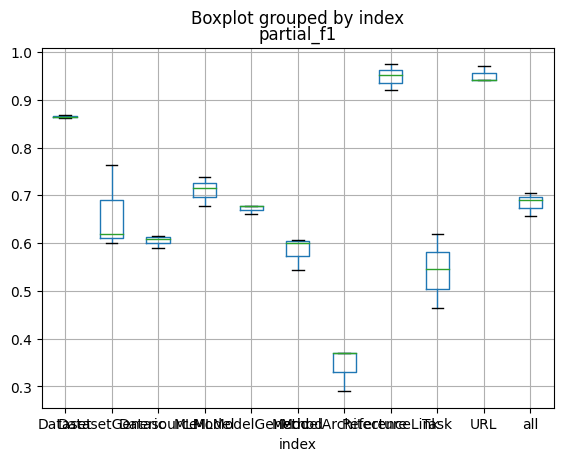

In [151]:
all_scores.boxplot(column="partial_f1", by="index")

In [152]:
all_scores

,index,partial_precision,exact_precision,partial_recall,exact_recall,partial_f1,exact_f1,prediction,recall
0,Dataset,0.801515,0.790909,0.944643,0.932143,0.867213,0.855738,Suyash,Abdelrahman
1,DatasetGeneric,0.453800,0.389831,0.889244,0.759318,0.600932,0.515173,Suyash,Abdelrahman
2,Datasource,0.533333,0.447619,0.658824,0.552941,0.589474,0.494737,Suyash,Abdelrahman
3,MLModel,0.634731,0.612275,0.821705,0.792636,0.716216,0.690878,Suyash,Abdelrahman
4,MLModelGeneric,0.671053,0.608083,0.652689,0.589790,0.661744,0.598797,Suyash,Abdelrahman
5,Method,0.600597,0.468657,0.613747,0.477494,0.607101,0.473034,Suyash,Abdelrahman
6,ModelArchitecture,0.316964,0.236607,0.445860,0.337580,0.370522,0.278215,Suyash,Abdelrahman
7,ReferenceLink,0.957701,0.942516,0.992144,0.975309,0.974618,0.958632,Suyash,Abdelrahman
8,Task,0.546012,0.511247,0.715426,0.664894,0.619343,0.578035,Suyash,Abdelrahman
9,URL,0.944444,0.944444,1.000000,1.000000,0.971429,0.971429,Suyash,Abdelrahman


In [93]:
scores

,partial_precision,exact_precision,partial_recall,exact_recall,partial_f1,exact_f1
Corrupt,0.076923,0.000000,0.200000,0.000000,0.111111,NaN
Dataset,0.801515,0.790909,0.944643,0.932143,0.867213,0.855738
Dataset/description,0.000000,0.000000,NaN,NaN,NaN,NaN
Dataset/size,0.000000,0.000000,NaN,NaN,NaN,NaN
DatasetGeneric,0.453800,0.389831,0.889244,0.759318,0.600932,0.515173
Datasource,0.533333,0.447619,0.658824,0.552941,0.589474,0.494737
IntentionComparison,0.400000,0.388235,0.306306,0.297297,0.346939,0.336735
IntentionCreation,0.724138,0.689655,0.525000,0.500000,0.608696,0.579710
IntentionUsage,0.800000,0.800000,0.050000,0.050000,0.094118,0.094118
MLModel,0.634731,0.612275,0.821705,0.792636,0.716216,0.690878


,partial_precision,exact_precision
ReferenceLink,0.957701,0.942516
URL,0.944444,0.944444
Dataset,0.801515,0.790909
IntentionUsage,0.800000,0.800000
IntentionCreation,0.724138,0.689655
MLModelGeneric,0.671053,0.608083
MLModel,0.634731,0.612275
all,0.623572,0.560919
Method,0.600597,0.468657
Task,0.546012,0.511247


In [68]:
exact_tp.sum() / p

0.6235717036846835

In [14]:
documents_multi_annotated = (documents > 0).sum(axis=1) > 1
documents_multi_annotated = documents_multi_annotated[documents_multi_annotated]
documents_multi_annotated

document_name
00001_1911_02116.txt    True
00002_1810_04805.txt    True
00003_2103_00020.txt    True
00004_1908_04913.txt    True
00005_1806_02847.txt    True
00006_1907_11692.txt    True
00007_1910_01108.txt    True
00008_1910_13461.txt    True
00009_1810_09305.txt    True
00010_1904_06472.txt    True
00011_1704_05179.txt    True
00012_2102_07033.txt    True
00013_2104_08727.txt    True
00020_1606_05250.txt    True
00021_1805_12471.txt    True
00030_2107_07653.txt    True
00040_1908_08962.txt    True
00050_1406_2661.txt     True
10001_2211_07364.txt    True
10010_1906_00216.txt    True
10018_2208_04405.txt    True
10020_2001_00605.txt    True
10025_1903_07756.txt    True
10030_2001_00585.txt    True
10032_2005_03899.txt    True
10035_2010_00795.txt    True
10036_2011_13045.txt    True
10040_2112_07839.txt    True
10051_2010_13116.txt    True
dtype: bool